In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

from dl_portfolio.constant import (
    BASE_FACTOR_ORDER_DATASET1_4,
    BASE_FACTOR_ORDER_DATASET2_5,
    DATASET1_REF_CLUSTER,
    DATASET2_REF_CLUSTER,
)

from dl_portfolio.utils import get_features_order
from sklearn import metrics as skmetrics

from dl_portfolio.hedge import load_activation

from hedge_performance import (
    DATA_BASE_DIR_1, 
    PERF_DIR_1, 
    GARCH_BASE_DIR_1, 
    DATA_BASE_DIR_2, 
    PERF_DIR_2,
    GARCH_BASE_DIR_2,
)

AE_DIR1 = "final_models/ae/dataset1/m_0_seed_6_1682872204041201"
AE_DIR2 = "final_models/ae/dataset2/m_0_seed_1_168287486565735"

SAVE=True
save=SAVE
savedir = "paper_result_update/ae"
if save:
    if not os.path.isdir(savedir):
        os.makedirs(savedir)
   

# Factor interpretation

## Dataset 1

In [2]:
cv_loading = pd.read_pickle(f"{PERF_DIR_1}/cv_loading.p")
# Reorder matrix
for k in cv_loading:
    new_order = get_features_order(cv_loading[k], DATASET1_REF_CLUSTER)
    cv_loading[k] = cv_loading[k].iloc[:, new_order]
    cv_loading[k].columns = BASE_FACTOR_ORDER_DATASET1_4
    
# Compute avg_loading
avg_loading = pd.DataFrame(columns=BASE_FACTOR_ORDER_DATASET1_4, index=cv_loading[0].index)
for f in BASE_FACTOR_ORDER_DATASET1_4:
    avg_loading[f] = pd.concat(list(cv_loading.values()), axis=1)[f].mean(axis=1)

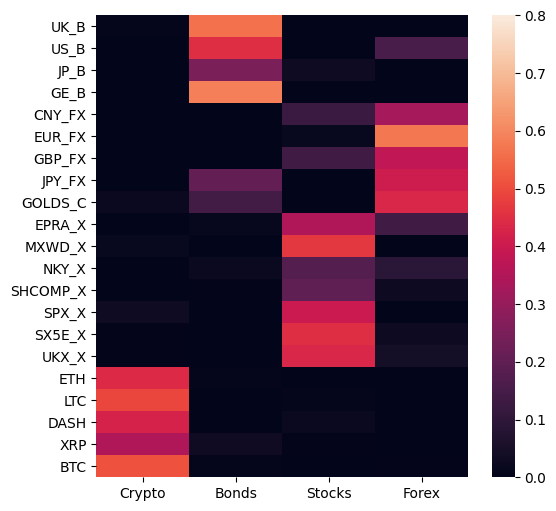

In [3]:
save=SAVE
plt.figure(figsize=(6,6))
sns.heatmap(avg_loading, vmin=0, vmax=0.8)
if save:
    plt.savefig(f"{savedir}/avg_loading_dataset1.png", transparent=True, bbox_inches="tight")
plt.show()

## Dataset 2

In [4]:
cv_loading = pd.read_pickle(f"{PERF_DIR_2}/cv_loading.p")
# Reorder matrix
for k in cv_loading:
    new_order = get_features_order(cv_loading[k], DATASET2_REF_CLUSTER)
    cv_loading[k] = cv_loading[k].iloc[:, new_order]
    cv_loading[k].columns = BASE_FACTOR_ORDER_DATASET2_5
    
# Compute avg_loading
avg_loading = pd.DataFrame(columns=BASE_FACTOR_ORDER_DATASET2_5, index=cv_loading[0].index)
for f in BASE_FACTOR_ORDER_DATASET2_5:
    avg_loading[f] = pd.concat(list(cv_loading.values()), axis=1)[f].mean(axis=1)

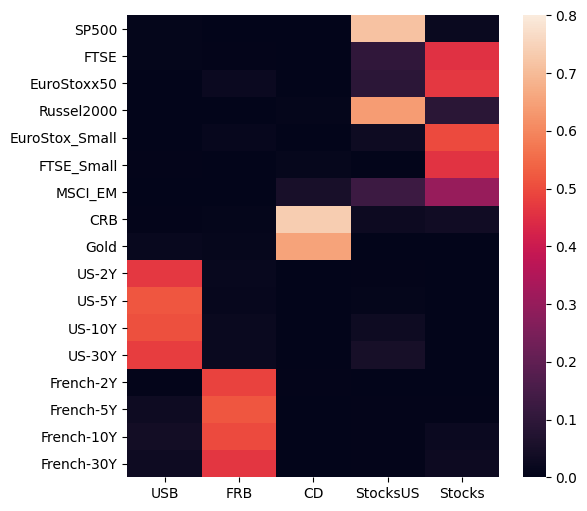

In [5]:
save=SAVE
plt.figure(figsize=(6,6))
sns.heatmap(avg_loading, vmin=0, vmax=0.8)
if save:
    plt.savefig(f"{savedir}/avg_loading_dataset2.png", transparent=True, bbox_inches="tight")
plt.show()

# Classifer performance

# Dataset 1

In [6]:
(
    train_activation, 
    test_activation, 
    train_probas, 
    test_probas, 
    predictions,
    models,
    _,
) = load_activation(
    DATA_BASE_DIR_1, AE_DIR1, GARCH_BASE_DIR_1, PERF_DIR_1, "dataset1")
test_target = (test_activation <= 0).astype(int)

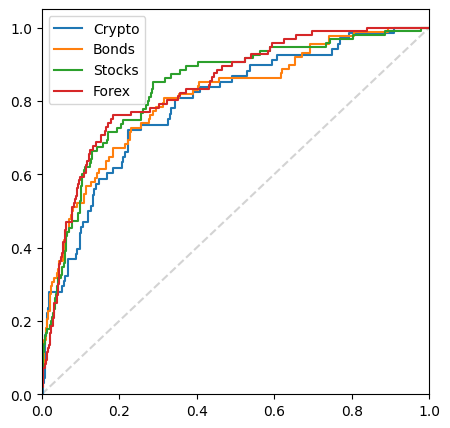

{'Crypto': 0.7920951156812339, 'Bonds': 0.8079205137310606, 'Stocks': 0.8348215207738114, 'Forex': 0.8356511780104712}


In [7]:
save=False
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], color="lightgrey", linestyle="--")
roc_auc = {}
for c in predictions:
    temp = test_probas[c].dropna()
    fpr, tpr, t = skmetrics.roc_curve(test_target.loc[temp.index, c], temp)
    roc_auc[c] = skmetrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=c)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
if save:
    plt.savefig(f"{savedir}/roc_curve_d1.png", transparent=True, bbox_inches="tight")
else:
    plt.legend()
plt.show()
print(roc_auc)

In [12]:
true_exceedances = (test_activation <= 0).sum() / len(test_activation)
excess_exceedances = (predictions == 1).sum() / len(predictions) - true_exceedances

(pd.concat([true_exceedances, excess_exceedances], axis=1).T * 100).round(2)

,Crypto,Bonds,Stocks,Forex
0,4.19,5.42,5.85,5.91
1,7.14,7.88,4.00,6.10


# Dataset 2

In [13]:
(
    train_activation, 
    test_activation, 
    train_probas, 
    test_probas, 
    predictions,
    models,
    _,
) = load_activation(
    DATA_BASE_DIR_2, AE_DIR2, GARCH_BASE_DIR_2, PERF_DIR_2, "dataset2")
test_target = (test_activation <= 0).astype(int)

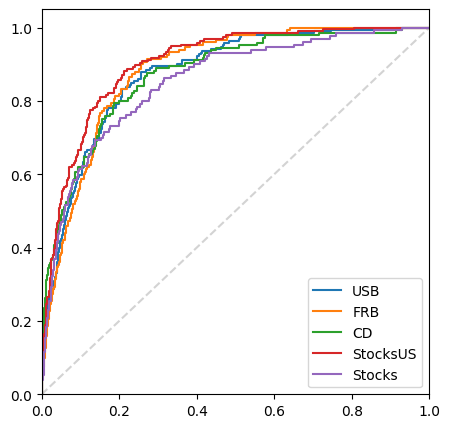

{'USB': 0.8762287377889676, 'FRB': 0.8840285296897825, 'CD': 0.8740868421754081, 'StocksUS': 0.9032994577918732, 'Stocks': 0.8535760573831314}


In [14]:
save=False
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], color="lightgrey", linestyle="--")
roc_auc = {}
for c in predictions:
    temp = test_probas[c].dropna()
    fpr, tpr, t = skmetrics.roc_curve(test_target.loc[temp.index, c], temp)
    roc_auc[c] = skmetrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=c)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
if save:
    plt.savefig(f"{savedir}/roc_curve_d2.png", transparent=True, bbox_inches="tight")
else:
    plt.legend()
plt.show()
print(roc_auc)

In [15]:
true_exceedances = (test_activation <= 0).sum() / len(test_activation)
excess_exceedances = (predictions == 1).sum() / len(predictions) - true_exceedances

(pd.concat([true_exceedances, excess_exceedances], axis=1).T * 100).round(2)

,USB,FRB,CD,StocksUS,Stocks
0,2.42,1.90,1.83,2.47,1.64
1,4.97,5.75,4.15,10.56,9.77
